In [2]:
import numpy as np
import datetime as dt
import spiceypy as spice
import matplotlib.pyplot as plt
from spacepy import pycdf

In [30]:
def print_info(cdf_file):
    for var_name in cdf_file.keys():
        print(f"Variable: {var_name}")
        print(f"  Data Type: {cdf_file[var_name].type()}")
        print(f"  Dimensions: {cdf_file[var_name].shape}")
        print(f"  Attributes: {cdf_file[var_name].attrs}")
        print()
    return

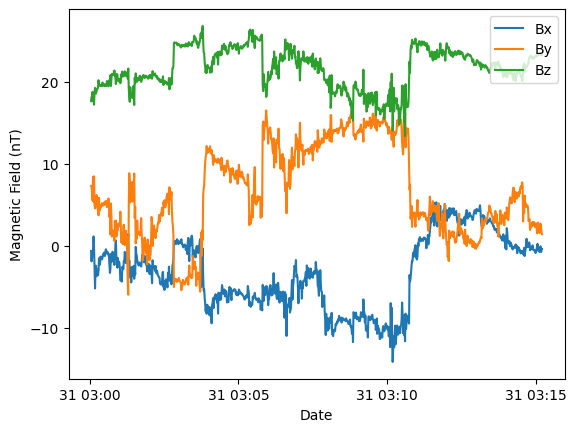

In [3]:
jmag_cdf = pycdf.CDF('../DATA/jmag_echoed/2025/03/31/JUICE_LU_RPWI-PPTD-LWYRPW79710_20250331T030003_V01.cdf')

Bx = jmag_cdf['LWT79713'][...]
By = jmag_cdf['LWT79714'][...]
Bz = jmag_cdf['LWT79715'][...]
jmag_epoch = jmag_cdf['Epoch'][...]

# Rotation matrix to go from JMAG frame to JUICE frame
R = np.array([
    [-7.77145961*1e-1,  8.39299198*1e-17,   -6.29320391*1e-1],
    [-9.51729314*1e-17, -1.00000000*1e0,    -1.58371803*1e-17],
    [-6.29320391*1e-1,  4.75864657*1e-17,   7.77145961*1e-1]])

# Rotate the magnetic field vectors to the JUICE frame
Bx_rot = R[0,0]*Bx + R[0,1]*By + R[0,2]*Bz
By_rot = R[1,0]*Bx + R[1,1]*By + R[1,2]*Bz
Bz_rot = R[2,0]*Bx + R[2,1]*By + R[2,2]*Bz
Bx = Bx_rot
By = By_rot
Bz = Bz_rot

plt.plot(jmag_epoch, Bx, label='Bx')
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Magnetic Field (nT)')
plt.show()

pycdf.CDF.close(jmag_cdf)

139886025.9621548
Delta time: 5.266309296413032 hours


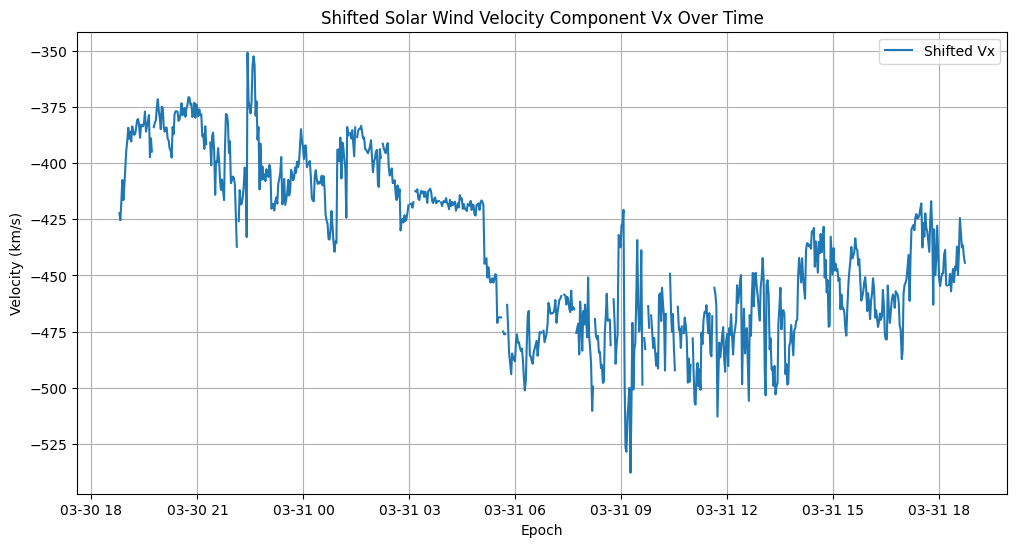

In [ ]:
sw_cdf = pycdf.CDF("../DATA\wi_k0s_swe_20250331000326_20250331235905_cdaweb.cdf")

# Extracting solar wind velocity components and spacecraft position components
V_GSE = sw_cdf['V_GSE'][...]
WIND_pos_gse = sw_cdf['SC_pos_gse'][...]
Epoch = sw_cdf['Epoch'][...]

V_GSE[V_GSE < -1e5] = np.nan

# Load the necessary SPICE kernels
spice.furnsh("../SPICE/kernels/mk/juice_personnal.tm")

# Specify time (UTC)
et = spice.str2et("2025-03-31T00:00:00")

# Get Earth's position relative to the Sun in J2000 frame
pos_earth_j2000, light_time = spice.spkpos("EARTH", et, "J2000", "NONE", "SUN")

distance_earth_sun = np.linalg.norm(pos_earth_j2000)

WIND_pos_sun_centered_x = WIND_pos_gse[:, 0] - distance_earth_sun

WIND_distance_sun = np.sqrt(WIND_pos_sun_centered_x**2 + WIND_pos_gse[:, 1]**2 + WIND_pos_gse[:, 2]**2)

# Calculate the average of SC_distance_sun
avrg_WIND_distance_sun = np.nanmean(WIND_distance_sun)

pos_juice_j2000, light_time = spice.spkpos("JUICE", et, "J2000", "NONE", "SUN")
distance_juice_sun = np.linalg.norm(pos_juice_j2000)

delta_distance = avrg_WIND_distance_sun - distance_juice_sun
sw_speed = -np.nanmean(V_GSE[:, 0], axis=0)
delta_time = delta_distance / sw_speed
print(f"Delta time: {delta_time/(60*60)} hours")

# Shift the solar wind data to delta_time seconds earlier
SW_epoch = Epoch - dt.timedelta(seconds=delta_time)
plt.figure(figsize=(12, 6))
plt.plot(SW_epoch, V_GSE[:, 0], label='Shifted Vx')
plt.title('Shifted Solar Wind Velocity Component Vx Over Time')
plt.xlabel('Epoch')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.grid()
plt.show()

pycdf.CDF.close(sw_cdf)
spice.unload("SPICE/kernels/mk/juice_personnal.tm")

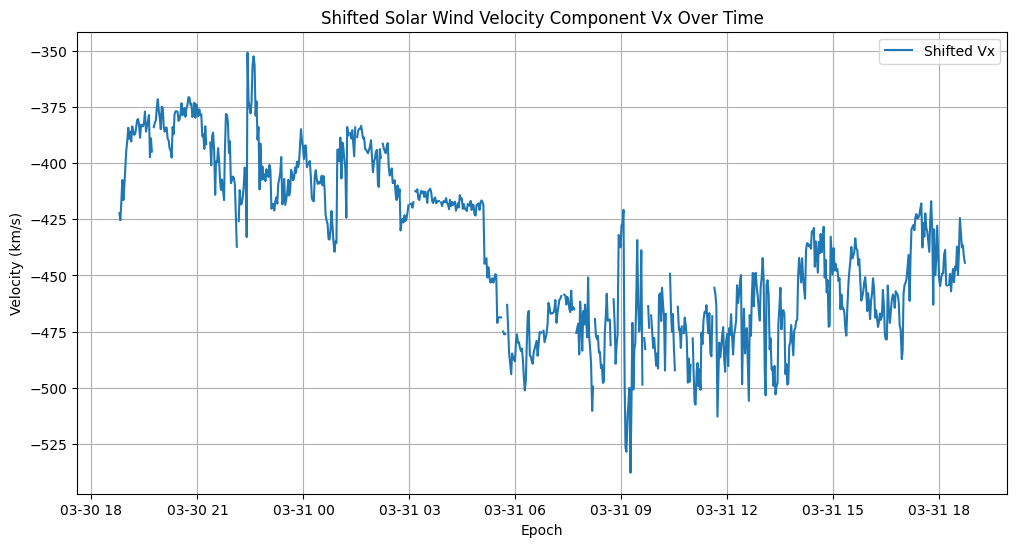

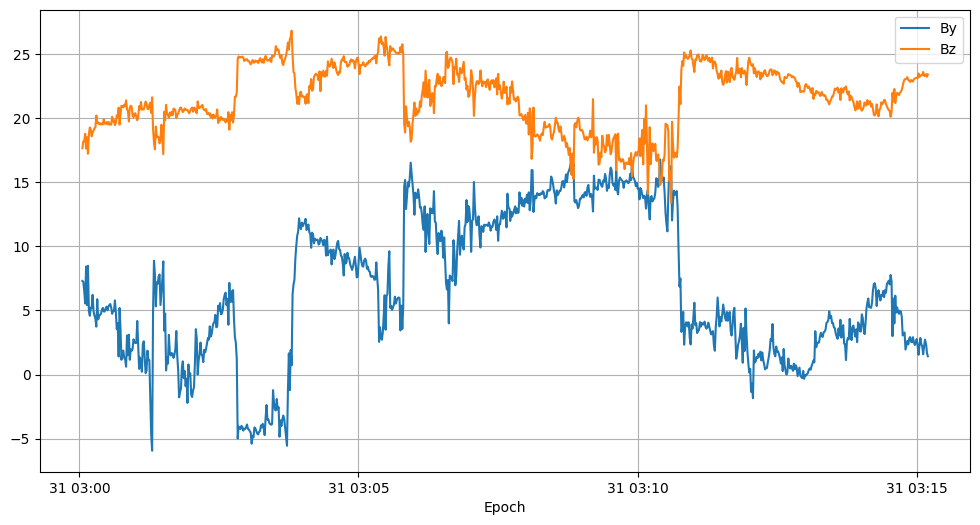

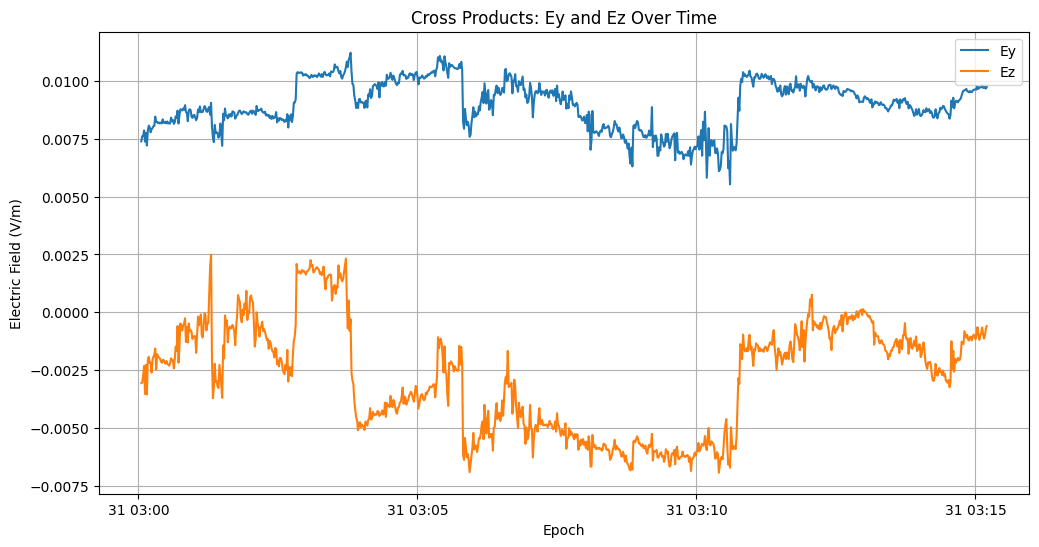

In [27]:
# X axis for JUICE points away from HGA antenna, so AWAY from the Sun, so SW speed needs to be positive (just don't put the minus sign in the formula)

# Ensure SW_epoch and V_GSE are available
cross_products = np.zeros((len(jmag_epoch), 3))

for i in range(len(jmag_epoch)):
    # Calculate the absolute time difference
    time_diffs = np.abs(SW_epoch - jmag_epoch[i])
    # Sort the indices of time differences in ascending order
    sorted_indices = np.argsort(time_diffs)
    
    # Find the first non-nan Vx value
    sw_vx = np.nan
    for idx in sorted_indices:
        if not np.isnan(V_GSE[idx, 0]):
            sw_vx = V_GSE[idx, 0]
            break
    
    cross_products[i] = [0, float(-Bz[i] * sw_vx * 1e-6), float(By[i] * sw_vx * 1e-6)]

plt.figure(figsize=(12, 6))
plt.plot(SW_epoch, V_GSE[:, 0], label='Shifted Vx')
plt.title('Shifted Solar Wind Velocity Component Vx Over Time')
plt.xlabel('Epoch')
plt.ylabel('Velocity (km/s)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, By, label='By')
plt.plot(jmag_epoch, Bz, label='Bz')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(jmag_epoch, cross_products[:, 1], label='Ey')
plt.plot(jmag_epoch, cross_products[:, 2], label='Ez')
plt.title('Cross Products: Ey and Ez Over Time')
plt.xlabel('Epoch')
plt.ylabel('Electric Field (V/m)')
plt.legend()
plt.grid()
plt.show()

Indices of removed values from TM_units_1: [    11     12     13     15     16     17     20  18703  18704  18705
  37386  37389  37390  37391  37392  37393  37394  37395  56074  56076
  56078  56079  56080  56081  56083  56085  74761  74764  74765  74766
  74767  74768  74769  74770  74772  74775  93449  93452  93453  93454
  93455  93456  93457  93458  93459  93460  93461  93463 112142 112143
 130828 130829 130830 130832 130833 130834 130835 149514 149515 149516
 149517 149518 149519 149520 149521 149522 149523 149524 168206 168207
 168208 168210 186892 186893 186894 186896 186897 186898 186899 205579
 205580 205581 205582 205583 205584 205585 205586 205587 205589 205590
 224268 224269 224270 224271 224272 224273 224274 242956 242957 242959
 242960 242961 242962 261645 261646 261647 261648 278029 278030 278031
 278032 278033 278034 278035 296716 296717 296718 296719 296720 296721
 296722 296723 296726 315405 315406 315407 315408 315409 315410 315411
 315412 334091 334092 334093 33409

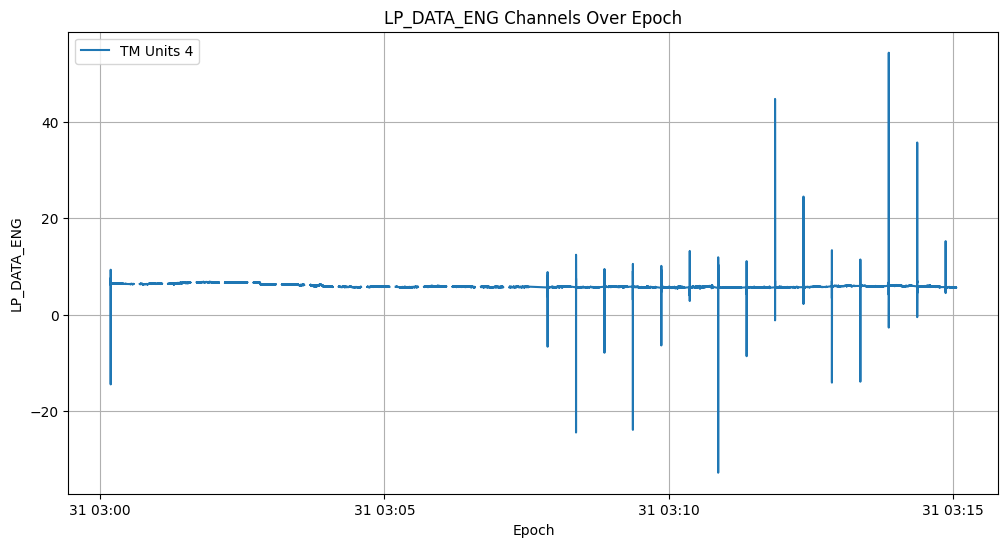

In [4]:
LP_cdf = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID1_RICH_DE763_SNAP_20250331T030011_V02.cdf')
#print_info(LP_cdf)

nb_values_removed = 11000

# Extracting the four channels of LP_DATA_ENG
lp_channel_1 = LP_cdf['LP_DATA_ENG'][:, 0][:-nb_values_removed]
lp_channel_2 = LP_cdf['LP_DATA_ENG'][:, 1][:-nb_values_removed]
lp_channel_3 = LP_cdf['LP_DATA_ENG'][:, 2][:-nb_values_removed]
lp_channel_4 = LP_cdf['LP_DATA_ENG'][:, 3][:-nb_values_removed]

TM_units_1 = LP_cdf['LP_DATA'][:, 0][:-nb_values_removed]
TM_units_2 = LP_cdf['LP_DATA'][:, 1][:-nb_values_removed]
TM_units_3 = LP_cdf['LP_DATA'][:, 2][:-nb_values_removed]
TM_units_4 = LP_cdf['LP_DATA'][:, 3][:-nb_values_removed]

coeffs_TM2voltage = np.array([[5.15*1e-6], [4.97*1e-6], [5.07*1e-6], [9.94*1e-5]])

TM_units_1 = TM_units_1 * coeffs_TM2voltage[0, 0]
TM_units_2 = TM_units_2 * coeffs_TM2voltage[1, 0]
TM_units_3 = TM_units_3 * coeffs_TM2voltage[2, 0]
TM_units_4 = TM_units_4 * coeffs_TM2voltage[3, 0]

lp_epoch = LP_cdf['Epoch'][...][:-nb_values_removed]

# Calculate the average of each TM_unit list
avg_TM_units_1 = np.mean(TM_units_1)
avg_TM_units_2 = np.mean(TM_units_2)
avg_TM_units_3 = np.mean(TM_units_3)
avg_TM_units_4 = np.mean(TM_units_4)

removed_indices_1 = np.where(np.abs(TM_units_4 - avg_TM_units_4) > 1)[0]
print("Indices of removed values from TM_units_1:", removed_indices_1)

differences_removed_indices_1 = np.diff(removed_indices_1)
print("Differences between consecutive removed indices:", differences_removed_indices_1)

for start_idx in range(10, len(TM_units_4), 18690):
    TM_units_4[start_idx-300:start_idx + 500] = np.nan

# Make values diverging by more than 1 from the average NaN
#TM_units_1[np.abs(TM_units_1 - avg_TM_units_1) > 1] = np.nan
#TM_units_2[np.abs(TM_units_2 - avg_TM_units_2) > 1] = np.nan
#TM_units_3[np.abs(TM_units_3 - avg_TM_units_3) > 1] = np.nan
#TM_units_4[np.abs(TM_units_4 - avg_TM_units_4) > 1] = np.nan

# Plotting the four channels over epoch
plt.figure(figsize=(12, 6))
#plt.plot(lp_epoch, lp_channel_1, label='Channel 1')
#plt.plot(lp_epoch, lp_channel_2, label='Channel 2')
#plt.plot(lp_epoch, lp_channel_3, label='Channel 3')
#plt.plot(lp_epoch, lp_channel_4, label='Channel 4')
#plt.plot(lp_epoch, TM_units_1, label='TM Units 1')
#plt.plot(lp_epoch, TM_units_2, label='TM Units 2')
#plt.plot(lp_epoch, TM_units_3, label='TM Units 3')
plt.plot(lp_epoch, TM_units_4, label='TM Units 4')
plt.title('LP_DATA_ENG Channels Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('LP_DATA_ENG')
plt.legend()
plt.grid()
plt.show()

pycdf.CDF.close(LP_cdf)

(4, 5120)
(4, 5120)
[-5.9768832e+02 -5.9768832e+02 -5.9768832e+02 ... -1.0000000e+31
 -1.0000000e+31 -1.0000000e+31]


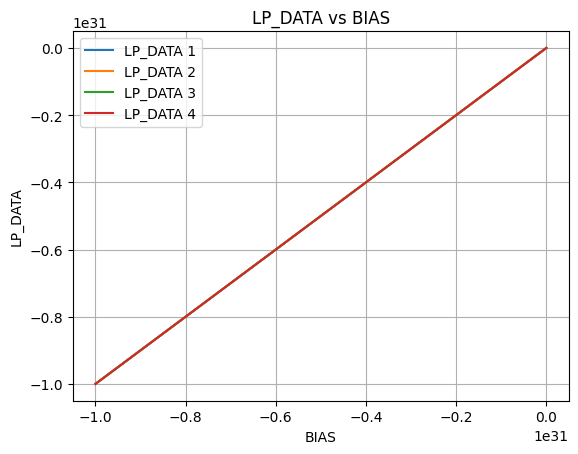

'\n# Displaying detailed information about the variables in the CDF file\nfor var_name in cdf_file.keys():\n    print(f"Variable: {var_name}")\n    print(f"  Data Type: {cdf_file[var_name].type()}")\n    print(f"  Dimensions: {cdf_file[var_name].shape}")\n    print(f"  Attributes: {cdf_file[var_name].attrs}")\n    print()\n'

In [ ]:
# Sweeps

cdf_file = pycdf.CDF('../DATA/JUICE_L1a_RPWI-LP-SID2_SRVY_SWEEP_20250331T032129_V01.cdf')
#print(cdf_file)

# Extracting the Epoch and LP_DATA_ENG variables
epoch = cdf_file['Epoch'][...]
# Extracting all LP_DATA for all probes and samples
lp_data = cdf_file['LP_DATA_ENG'][...]


# Reshaping lp_data to extract 48 arrays of size 4*5120
filtered_lp_data = [lp_data[i, :, :] for i in range(48)]

print(filtered_lp_data[0].shape)

# Extracting all BIAS data for all probes and samples
bias_data = cdf_file['BIAS_ENG'][...]

# Reshaping bias_data to extract 48 arrays of size 4*5120
filtered_bias_data = [bias_data[i, :, :] for i in range(48)]

print(filtered_bias_data[0].shape)

print(filtered_bias_data[0][0, :])

plt.plot(filtered_bias_data[0][0, :], filtered_lp_data[0][0, :])
plt.plot(filtered_bias_data[0][1, :], filtered_lp_data[0][1, :])
plt.plot(filtered_bias_data[0][2, :], filtered_lp_data[0][2, :])
plt.plot(filtered_bias_data[0][3, :], filtered_lp_data[0][3, :])
plt.title('LP_DATA vs BIAS')
plt.xlabel('BIAS')
plt.ylabel('LP_DATA')
plt.legend(['LP_DATA 1', 'LP_DATA 2', 'LP_DATA 3', 'LP_DATA 4'])
plt.grid()
plt.show()

"""
# Displaying detailed information about the variables in the CDF file
for var_name in cdf_file.keys():
    print(f"Variable: {var_name}")
    print(f"  Data Type: {cdf_file[var_name].type()}")
    print(f"  Dimensions: {cdf_file[var_name].shape}")
    print(f"  Attributes: {cdf_file[var_name].attrs}")
    print()
"""